# Clip part of patch that is behind text

In [1]:
import numpy as np
import shapely.geometry
import shapely.geometry.polygon
import shapely.geometry.multilinestring

import matplotlib.pyplot as plt
from matplotlib import patches, transforms, collections, cm
from matplotlib.path import Path
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def mpl_to_shapely(mpl, **kwargs):
    if isinstance(mpl, transforms.Bbox):
        return shapely.geometry.box(mpl.x0, mpl.y0, mpl.x0+mpl.width, mpl.y0+mpl.height)

def shapely_to_mpl(shape, **kwargs):
    """Convert shapely to mpl Polygon.
        
        If PolygonCollection try instead to convert largest polygon.
    """
    if isinstance(shape, shapely.geometry.polygon.Polygon):
        # return mpl Polygon if possible
        if isinstance(shape.boundary, shapely.geometry.linestring.LineString):
            return patches.Polygon(zip(*shape.exterior.xy),
                                      **kwargs)
        elif isinstance(shape.boundary, shapely.geometry.multilinestring.MultiLineString):
            verts = []
            codes = []
            for geom in shape.boundary.geoms:
                nverts = zip(*geom.xy)
                ncodes = [Path.MOVETO]
                ncodes.extend([Path.LINETO for i in range(len(nverts)-2)])
                ncodes.append(Path.CLOSEPOLY)
                verts.extend(nverts) 
                codes.extend(ncodes)
            path = Path(verts, codes)
            return patches.PathPatch(path, **kwargs)
    elif isinstance(shape, shapely.geometry.multipolygon.MultiPolygon):
        # MultiPolygon instead of Polygon --> convert largest polygon in collection
        polygon = sorted(shape.geoms, key=lambda x: x.area)[-1]
        return patches.Polygon(zip(*polygon.exterior.xy),
                                      **kwargs)
    elif isinstance(shape, shapely.geometry.multilinestring.MultiLineString):
        lines = [zip(*line.xy) for line in shape.geoms]
        return collections.LineCollection(lines,
                                                     **kwargs)

Path(array([[ 0.7       ,  0.3       ],
       [ 0.3       ,  0.3       ],
       [ 0.3       ,  0.7       ],
       [ 0.7       ,  0.7       ],
       [ 0.7       ,  0.3       ],
       [ 0.5741381 ,  0.45169355],
       [ 0.5741381 ,  0.54830645],
       [ 0.4258619 ,  0.54830645],
       [ 0.4258619 ,  0.45169355],
       [ 0.5741381 ,  0.45169355]]), array([ 1,  2,  2,  2, 79,  1,  2,  2,  2, 79], dtype=uint8))


([], <a list of 0 Text yticklabel objects>)

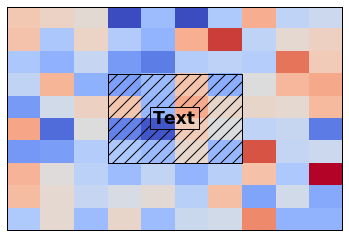

In [3]:
fig, ax = plt.subplots()
imdata = np.random.randn(10, 10)
ax.imshow(imdata, extent=(0, 1, 0, 1), aspect='auto', cmap=cm.coolwarm)
box = shapely.geometry.box(0.3, 0.3, 0.7, 0.7)
text = ax.text(0.5, 0.5, 'Text', fontsize='xx-large', fontweight='bold', color='k', ha='center', va='center')
renderer = ax.figure.canvas.get_renderer()
bbox = text.get_window_extent(renderer)
bbox_points = bbox.transformed(ax.transAxes.inverted()).get_points()
pad = 0.01
bbox_points[0] -= pad
bbox_points[1] += pad
bbox_points = ax.transData.inverted().transform(ax.transAxes.transform(bbox_points))
bbox_shapely = shapely.geometry.box(*bbox_points.flatten())
patch = shapely_to_mpl(box-bbox_shapely, edgecolor='k', facecolor='none', lw=1.0, alpha=1.0, hatch=r'//')
ax.add_patch(patch)
print patch.get_path()
plt.xticks([])
plt.yticks([])

In [4]:
bbox.get_points()

array([[ 222.140625,  154.5     ],
       [ 269.859375,  173.5     ]])

Path(array([[ 0.3       ,  0.3       ],
       [ 0.7       ,  0.3       ],
       [ 0.7       ,  0.7       ],
       [ 0.3       ,  0.7       ],
       [ 0.3       ,  0.3       ],
       [ 0.4358619 ,  0.46169355],
       [ 0.5641381 ,  0.46169355],
       [ 0.5641381 ,  0.53830645],
       [ 0.4358619 ,  0.53830645],
       [ 0.4358619 ,  0.46169355]]), array([ 1,  2,  2,  2, 79,  1,  2,  2,  2, 79], dtype=uint8))


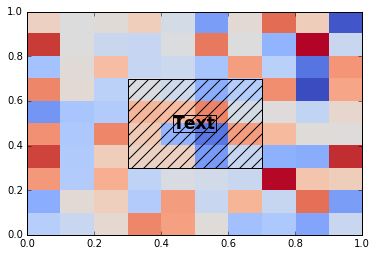

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, cm
from matplotlib.path import Path
fig, ax = plt.subplots()
imdata = np.random.randn(10, 10)
ax.imshow(imdata, extent=(0, 1, 0, 1), aspect='auto', cmap=cm.coolwarm)
text = ax.text(0.5, 0.5, 'Text', fontsize='xx-large', fontweight='bold',
               color='k', ha='center', va='center')
renderer = fig.canvas.get_renderer()
bbox = text.get_window_extent(renderer).transformed(ax.transData.inverted())
bboxrect = patches.Rectangle((bbox.x0, bbox.y0), bbox.width, bbox.height)
bbpath = bboxrect.get_path().transformed(bboxrect.get_patch_transform())
patch = patches.Rectangle((0.3, 0.3), 0.4, 0.4)
path = patch.get_path().transformed(patch.get_patch_transform())
path = Path.make_compound_path(path, bbpath)
patch = patches.PathPatch(path, facecolor='none', hatch=r'//')
ax.add_patch(patch)
print patch.get_path()

Bbox(x0=4.4408920985e-16, y0=-0.0322580645161, x1=0.110215053763, y1=0.129032258065)


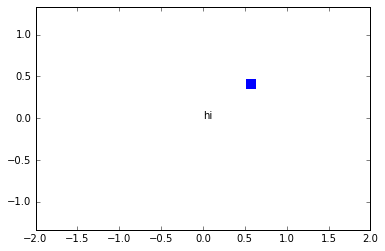

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib.transforms import Bbox

# This is in PIXELS
# first tuple : coords of box' bottom-left corner, from the figure's bottom-left corner
# second tuple : coords of box' top-right corner, from the figure's bottom-left corner
clip_box = Bbox(((0,0),(200,200)))
circle = Circle((0,0), 1, clip_on=True)

plt.axis('equal')
plt.axis((-2,2,-2,2))
plt.axes().add_artist(circle)
ax = plt.gca()
text = plt.text(0, 0, 'hi')
renderer = fig.canvas.get_renderer()
bbox = text.get_window_extent(renderer).transformed(ax.transData.inverted())
print bbox
rect = Rectangle([bbox.x0, bbox.y0], bbox.width, bbox.height, color = [0,0,0], fill = False)

# You have to call this after add_artist()
circle.set_clip_box(bbox.transformed(ax.transData))
#circle.set_clip_path(rect)